In [1]:
# Install necessary libraries
!pip install wordcloud
!pip install tensorflow

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings

In [3]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabby\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gabby\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gabby\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabby\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# to print out all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set random seed for reproducibility
random.seed(493)
tf.random.set_seed(493)

In [5]:
# Read tsv data
colnames = ['text', 'label'] 
amazon = pd.read_csv(r'C:\Users\gabby\Documents\Masters program\D213\Task 2\sentiment labelled sentences\amazon_cells_labelled.txt', sep='\t', names=colnames, header=None)
imdb = pd.read_csv(r'C:\Users\gabby\Documents\Masters program\D213\Task 2\sentiment labelled sentences\imdb_labelled.txt', sep='\t', names=colnames, header=None)
yelp = pd.read_csv(r'C:\Users\gabby\Documents\Masters program\D213\Task 2\sentiment labelled sentences\yelp_labelled.txt', sep='\t', names=colnames, header=None)

In [6]:
# Combine all reviews into one dataframe
reviews = pd.concat([yelp, amazon, imdb], ignore_index=True)

In [7]:
# Check for any nulls
print("Null Values in Reviews:\n", reviews.isna().sum())

Null Values in Reviews:
 text     0
label    0
dtype: int64


In [8]:
# Print first 5 rows 
print(reviews.head())

                                                text  label
0                           Wow... Loved this place.      1
1                                 Crust is not good.      0
2          Not tasty and the texture was just nasty.      0
3  Stopped by during the late May bank holiday of...      1
4  The selection on the menu was great and so wer...      1


In [9]:
# Exploratory Data Analysis
print(f"Shape of data: {reviews.shape}")
print(f"Sentiment counts: \n{reviews['label'].value_counts()}")
print(f"Missing values: \n{reviews.isna().sum()}")

Shape of data: (2748, 2)
Sentiment counts: 
label
1    1386
0    1362
Name: count, dtype: int64
Missing values: 
text     0
label    0
dtype: int64


In [10]:
# Check for unusual characters
unusual_chars = reviews['text'].str.extractall(r'([^a-zA-Z0-9\s])') 
unusual_chars_count = unusual_chars[0].value_counts()
print(unusual_chars_count)

0
.    3093
,    1306
'     723
!     503
-     294
"     120
)     103
(      94
/      42
:      39
&      28
?      28
;      25
$      18
*      18
é       7
+       6
%       5
       5
#       2
ê       1
[       1
]       1
å       1
       1
Name: count, dtype: int64


In [11]:
# Vocabulary Size
vectorizer = CountVectorizer()
vectorizer.fit(reviews['text'])
vocabulary_size = len(vectorizer.vocabulary_)
print("Vocabulary Size:", vocabulary_size)

CountVectorizer()

Vocabulary Size: 5155


In [12]:
# Calculate review lengths
reviews['length'] = reviews['text'].apply(lambda x: len(x.split()))

In [13]:
# Statistical Justification for Maximum Sequence Length
print(f'Mean Length: {reviews["length"].mean()}')
print(f'Median Length: {reviews["length"].median()}')
print(f'Max Length: {reviews["length"].max()}')
print(f'95th Percentile: {reviews["length"].quantile(0.95)}')

Mean Length: 13.006550218340612
Median Length: 10.0
Max Length: 1390
95th Percentile: 26.0


In [14]:
# Make the 95% the max length
max_length = 26

In [15]:
# Text Normalization
def clean_text(text):
    # Convert all text to lowercase, remove punctuation and single characters
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Remove punctuation
    text = re.sub(r'\s+[a-z]\s+', ' ', text)  # Remove single characters
    return text.lower()

reviews['text'] = reviews['text'].apply(clean_text)

In [16]:
# Initialize lemmatizer and get the list of stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [17]:
reviews.head()

,text,label,length
0,wow loved this place,1,4
1,crust is not good,0,4
2,not tasty and the texture was just nasty,0,8
3,stopped by during the late may bank holiday of...,1,15
4,the selection on the menu was great and so wer...,1,12


In [18]:
# Function to clean and lemmatize text
def preprocess_and_clean(text):
    # Remove URLs and special characters
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize and lemmatize
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

In [19]:
# Apply text cleaning
reviews['text'] = reviews['text'].apply(preprocess_and_clean)

In [20]:
# Add a column for word count and remove reviews with 3 words or less
reviews['Word_Count'] = reviews['text'].apply(lambda x: len(x.split()))
reviews = reviews[reviews['Word_Count'] > 3]

In [21]:
# Tokenization and model preparation
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews['text'])
sequences = tokenizer.texts_to_sequences(reviews['text'])

In [22]:
# Padding Process
padded_sequences = pad_sequences(sequences, padding='pre',truncating='pre', maxlen=max_length)
print("Padded Sequences:", padded_sequences[0]) 

Padded Sequences: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  860  861  233 1900 1901 1902  862  863  171]


In [23]:
# Exporting our prepped data
reviews.to_csv('cleaned_task2.csv', index = False)

In [24]:
# Train/test split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    padded_sequences, reviews['label'], test_size=0.2, random_state=42)  # 80/20 split

# Further split temp into validation and test sets (1/2 of the 20% each = 10% each)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42)  # 50% of the temp set

In [25]:
# print shape
print("Training set shape:", train_texts.shape, train_labels.shape)
print("Validation set shape:", val_texts.shape, val_labels.shape)
print("Test set shape:", test_texts.shape, test_labels.shape)

Training set shape: (1498, 26) (1498,)
Validation set shape: (187, 26) (187,)
Test set shape: (188, 26) (188,)


In [26]:
# Convert to DataFrames for saving
train_texts_df = pd.DataFrame(train_texts)
val_texts_df = pd.DataFrame(val_texts)
test_texts_df = pd.DataFrame(test_texts)

train_labels_df = pd.DataFrame(train_labels)
val_labels_df = pd.DataFrame(val_labels)
test_labels_df = pd.DataFrame(test_labels)

In [27]:
# Save to CSV files for B5
train_texts_df.to_csv('train_texts.csv', index=False, header=True)
val_texts_df.to_csv('val_texts.csv', index=False, header=True)
test_texts_df.to_csv('test_texts.csv', index=False, header=True)

train_labels_df.to_csv('train_labels.csv', index=False, header=True)
val_labels_df.to_csv('val_labels.csv', index=False, header=True)
test_labels_df.to_csv('test_labels.csv', index=False, header=True)

In [28]:
# Build the model
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=128, input_length=max_length))
model.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

In [29]:
# Compile the model
optimizer = Adam(learning_rate=1e-1)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [30]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
model.fit(train_texts, train_labels, validation_split=0.3, 
         callbacks= [early_stopping])

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.5306 - loss: 6.6061 - val_accuracy: 0.5111 - val_loss: 6.6718


In [31]:
# Fit the model
history = model.fit(train_texts, train_labels, epochs=15, batch_size=128, validation_data=(val_texts, val_labels), callbacks=[early_stopping])

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5127 - loss: 6.1170 - val_accuracy: 0.4706 - val_loss: 4.8339
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4996 - loss: 4.7652 - val_accuracy: 0.4652 - val_loss: 4.1865
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5222 - loss: 3.8799 - val_accuracy: 0.4706 - val_loss: 3.2702
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5175 - loss: 3.3908 - val_accuracy: 0.4759 - val_loss: 4.2145
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.5069 - loss: 4.7939 - val_accuracy: 0.5294 - val_loss: 6.9626
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5079 - loss: 7.9470 - val_accuracy: 0.5294 - val_loss: 11.2609


In [32]:
# Get overview of model
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 26, 128)        │       659,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 26, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,524,229 (9.63 MB)

 Trainable params: 841,281 (3.21 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 1,682,564 (6.42 MB)

None


<function seaborn.rcmod.set(*args, **kwargs)>

Text(0.5, 1.0, 'Training and validation accuracy')

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Training and validation loss')

<Figure size 640x480 with 0 Axes>

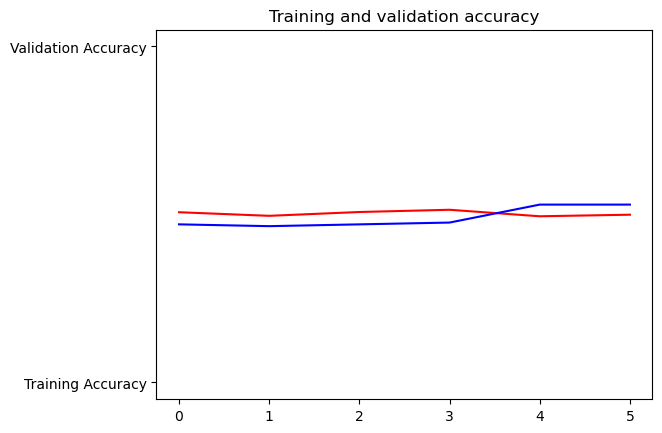

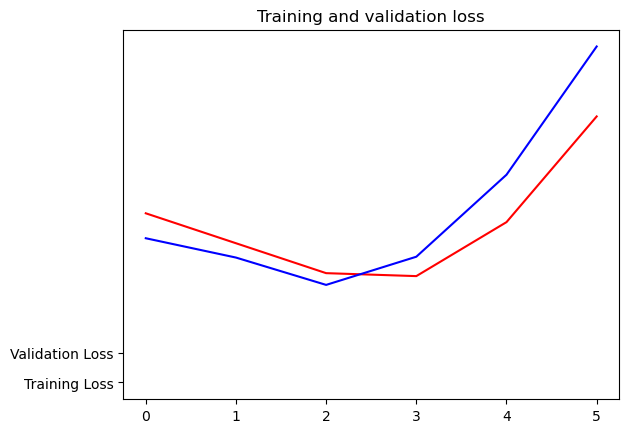

<Figure size 640x480 with 0 Axes>

In [33]:
# Training and validation accuracy
sns.set
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

In [34]:
# Save the model
model.save('D213_T2-model.keras')